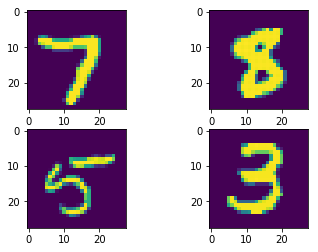

In [32]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
np.random.seed(10)

#X = mnist.data
#Y = mnist.target
#xlen = len(X)
#perm = np.random.permutation(xlen)
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
#xtrain, xtest = X[perm][10000:],X[perm][:10000]
#ytrain, ytest = Y[perm][10000:],Y[perm][:10000]
xtrain, xtest = xtrain.reshape(xtrain.shape[0],28,28,1).astype('float32')/255.0, xtest.reshape(xtest.shape[0],28,28,1).astype('float32')/255.0 
ytrain, ytest = np_utils.to_categorical(ytrain),np_utils.to_categorical(ytest)

f,ax =plt.subplots(2,2)
ax[0,0].imshow(X[42352].reshape(28,28))
ax[0,1].imshow(X[63563].reshape(28,28))
ax[1,0].imshow(X[18342].reshape(28,28))
ax[1,1].imshow(X[25685].reshape(28,28))
plt.show()

In [30]:
from tensorflow.keras import layers,models#,datasets
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                102464    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [34]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain, epochs=5, 
                    validation_data=(xtest, ytest))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
   32/60000 [..............................] - ETA: 8:12

ValueError: Shape mismatch: The shape of labels (received (320,)) should equal the shape of logits except for the last dimension (received (32, 10)).

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
import random
randomimage = xtrain[random.randint(0,len(xtrain))].reshape(28,28)
plt.imshow(randomimage)
outcome =model.predict(randomimage.reshape(1,28,28,1))
#print(outcome)
def get_result(outcome):
    result = 0
    maxpro = 0
    for pro in range(len(outcome[0])):
        if outcome[0][pro] >= maxpro:
            maxpro = outcome[0][pro]
            result = pro
    return result,maxpro
result,maxpro = get_result(outcome)
print(result)
print(maxpro)

In [ ]:
# task 2 adversarial
from keras.preprocessing import image
from keras import backend as K
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output
object_type_to_fake = 8
original_image = image.img_to_array(randomimage)
max_change_above = original_image + 0.01
max_change_below = original_image - 0.01
cost_function = model_output_layer[0, object_type_to_fake]
gradient_function = K.gradients(cost_function, model_input_layer)[0]
grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function])
print(grab_cost_and_gradients_from_model)
cost, grad = grab_cost_and_gradients_from_model([original_image ,0])
with tf.GradientTape() as tape:
  logits = model(randomimage.reshape(1,28,28,1))
  loss_value = loss(logits, result)
grads = tape.gradient(loss_value, model.trainable_variables)
optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
sess = K.get_session()
testdata_adv = randomimage

epochs = 1
epsilon = 0.1

loss = losses.mse(outcome,model.output)
grads = K.gradients(loss,model.input)
delta = K.sign(grads[0])
testdata_adv += epsilon*delta
testdata_adv = sess.run(testdata_adv, feed_dict={model.input:randomimage.reshape(1,28,28,1)})
testdata_adv = preprocessing.StandardScaler().fit_transform(testdata_adv)
score = model.evaluate(testdata_adv,testlabel,verbose=0,batch_size=64)
print(score)